## Import

In [1]:
import numpy as np
import pandas as pd## 🔍 EXPLORING THE DATASET 🦜
import os

import tensorflow as tf

## EXPLORING THE DATASET 

In [2]:
for dirpath, dirnames, filenames in os.walk('../Kaggle500Dataset/'):
    print(f'There Are {len(dirnames)} Directories And {len(filenames)} Images In {dirpath}')

There Are 4 Directories And 3 Images In ../Kaggle500Dataset/
There Are 510 Directories And 0 Images In ../Kaggle500Dataset/valid
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/CREAM COLORED WOODPECKER
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/CAMPO FLICKER
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/RUFUOS MOTMOT
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/WHITE TAILED TROPIC
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/KOOKABURRA
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/TREE SWALLOW
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/ORNATE HAWK EAGLE
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/AMERICAN REDSTART
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/EASTERN TOWEE
There Are 0 Directories And 5 Images In ../Kaggle500Dataset/valid/IBERIAN MAGPIE
There Are 0 Directories And 5 Images In ../Kaggle

In [3]:
# Getting The Number Of ClassNames
num_of_bird_groups = len(os.listdir('../Kaggle500Dataset/train'))
num_of_bird_groups

510

In [4]:
# Getting The ClassNames
import pathlib

data_dir = pathlib.Path('../Kaggle500Dataset/train')
classnames = np.array(sorted([item.name for item in data_dir.glob('*')]))
# classnames = np.delete(classnames, 0)
print(len(classnames))
# print(classnames, "")

510


### VISUALIZING 6 RANDOM IMAGES

In [5]:
# Function To Visualize The Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup The Target Directory
  target_folder = target_dir + target_class

  # Getting A Random Image Path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read In The Image And Plot It Using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  
  return img

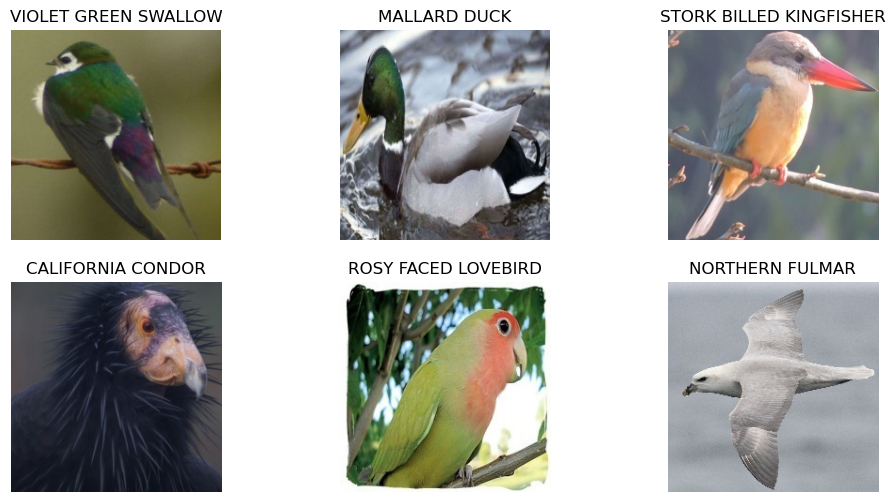

In [6]:
plt.figure(figsize = (12,6))

plt.subplot(231)
img1 = view_random_image('../Kaggle500Dataset/train/', "VIOLET GREEN SWALLOW")

plt.subplot(232)
img2 = view_random_image('../Kaggle500Dataset/train/', "MALLARD DUCK")

plt.subplot(233)
img3 = view_random_image('../Kaggle500Dataset/train/', "STORK BILLED KINGFISHER")

plt.subplot(234)
img4 = view_random_image('../Kaggle500Dataset/train/', "CALIFORNIA CONDOR")

plt.subplot(235)
img5 = view_random_image('../Kaggle500Dataset/train/', "ROSY FACED LOVEBIRD")

plt.subplot(236)
img5 = view_random_image('../Kaggle500Dataset/train/', "NORTHERN FULMAR")


## PREPROCESSING

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting The Random Seed
tf.random.set_seed(7)

# Setting Up Paths To Our Data Directories
train_dir = '../Kaggle500Dataset/train/'
test_dir = '../Kaggle500Dataset/test/'
val_dir = '../Kaggle500Dataset/valid'

# Preprocessing Data (Scaling/Normalization)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

# Importing Data From The Directories And Turning It Into Batches
train_data = train_datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode='categorical')

val_data = val_datagen.flow_from_directory(val_dir,
                                           batch_size=32,
                                           target_size=(224, 224),
                                           class_mode='categorical')

Found 81950 images belonging to 510 classes.
Found 2550 images belonging to 510 classes.
Found 2550 images belonging to 510 classes.


## LET'S USE DATA AUGMENTATION

In [8]:
# Creating Data Augmentation Layer With horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)
], name='DataAugmentationLayer')

###  VISUALIZING OUR DATA AUGMENTED IMAGES

(-0.5, 246.5, 218.5, -0.5)

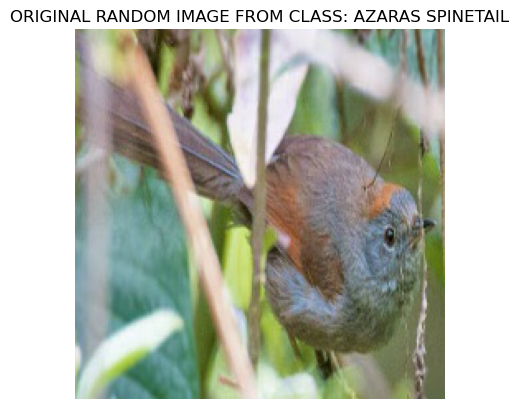

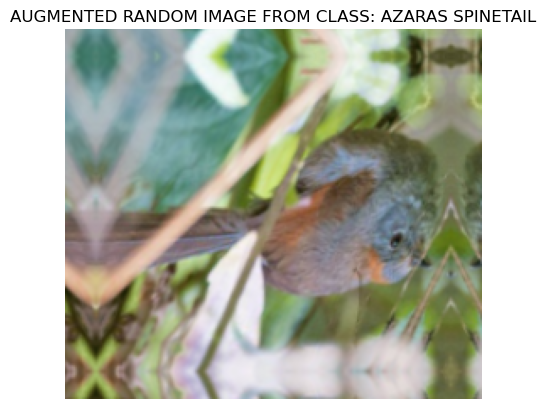

In [9]:
# Viewing A Random Image And Comparing It To Its Augmented Version
target_class = random.choice(classnames)
target_dir = '../Kaggle500Dataset/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read And Plot In The Random Image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'ORIGINAL RANDOM IMAGE FROM CLASS: {target_class}')
plt.axis(False);

# Now Let's Plot Our Augmented Random Image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'AUGMENTED RANDOM IMAGE FROM CLASS: {target_class}')
plt.axis(False)

###  🔥 MODEL 1 : A MODEL WITH DATA AUGMENTATION

In [10]:
# 1. Creating A Base Model With tf.keras.applications
base_model = tf.keras.applications.InceptionV3(include_top=False)

# 2. Freezing The Base Model
base_model.trainable = False

# 3. Creating Inputs Into Our Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='InputLayer')

# 4. Adding Data Augmentation Sequential Model As A Layer
x = data_augmentation(inputs)

# 4. Passing The Inputs To The Base Model
x = base_model(x, training=False)

# 5. Average Pooling The Outputs Of The Base Model
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

# 6. Creating The Output Activation Layer
outputs = tf.keras.layers.Dense(num_of_bird_groups, activation='softmax', name='OutputLayer')(x)

# 7. Combining The Inputs With The Outputs Into A Model
model_1 = tf.keras.Model(inputs, outputs)

# 8. Compiling The Model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentationLayer (Sequ  (None, 224, 224, 3)      0         
 ential)                                                         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 GlobalAveragePoolingLayer (  (None, 2048)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 OutputLayer (Dense)         (None, 510)               1044990   
                                                                 
Total params: 22,847,774
Trainable params: 1,044,990
Non-trai

In [11]:
# 9. Fitting The Model
history_1 = model_1.fit(train_data,
                       epochs=10,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=int(0.25*len(val_data)))

Epoch 1/10


2023-03-29 22:47:25.125272: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2561/2561 [==============================] - 1119s 436ms/step - loss: 3.3146 - accuracy: 0.3500 - val_loss: 1.5634 - val_accuracy: 0.6016
Epoch 2/10
2561/2561 [==============================] - 1138s 444ms/step - loss: 2.4745 - accuracy: 0.4931 - val_loss: 1.5173 - val_accuracy: 0.5797
Epoch 3/10
2561/2561 [==============================] - 1125s 439ms/step - loss: 2.3232 - accuracy: 0.5351 - val_loss: 1.3534 - val_accuracy: 0.6609
Epoch 4/10
2561/2561 [==============================] - 1136s 444ms/step - loss: 2.2269 - accuracy: 0.5615 - val_loss: 1.2163 - val_accuracy: 0.6766
Epoch 5/10
2561/2561 [==============================] - 1133s 443ms/step - loss: 2.1631 - accuracy: 0.5761 - val_loss: 1.2227 - val_accuracy: 0.6984
Epoch 6/10
2561/2561 [==============================] - 1132s 442ms/step - loss: 2.1164 - accuracy: 0.5911 - val_loss: 1.1452 - val_accuracy: 0.6953
Epoch 7/10
2561/2561 [==============================] - 1139s 445ms/step - loss: 2.0674 - accuracy: 0.6009 - val_loss

In [12]:
results_1 = model_1.evaluate(test_data)
results_1### 🖥 SAVING THE MODEL

80/80 [==============================] - 33s 414ms/step - loss: 1.0209 - accuracy: 0.7357


[1.0209441184997559, 0.7356863021850586]

### 🖥 SAVING THE MODEL

In [13]:
model_1.save(f'./Models/inceptionv3/data_aug_model_{results_1[1]}.h5')

### 📈 VISUALIZING THE LOSS CURVE

In [14]:
def plot_loss_curves(history):
  """
  Returns Separate Loss Curves For Training And Validation Metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plotting Loss
  plt.plot(epochs, loss, label='TRAINING_LOSS')
  plt.plot(epochs, val_loss, label='VAL_LOSS')
  plt.title('LOSS')
  plt.xlabel('EPOCHS')
  plt.legend()

  # Plotting Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='TRAINING_ACCURACY')
  plt.plot(epochs, val_accuracy, label='VAL_ACCURACY')
  plt.title('ACCURACY')
  plt.xlabel('EPOCHS')
  plt.legend()

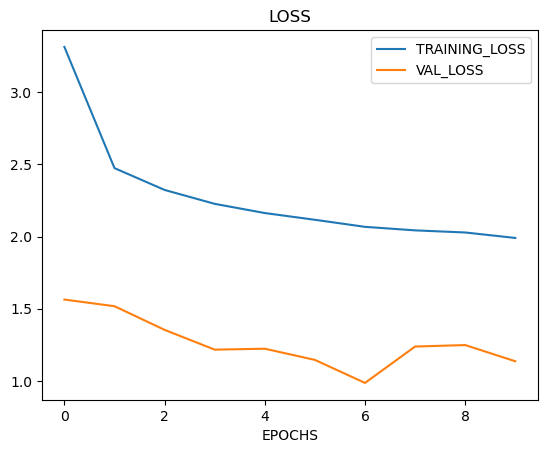

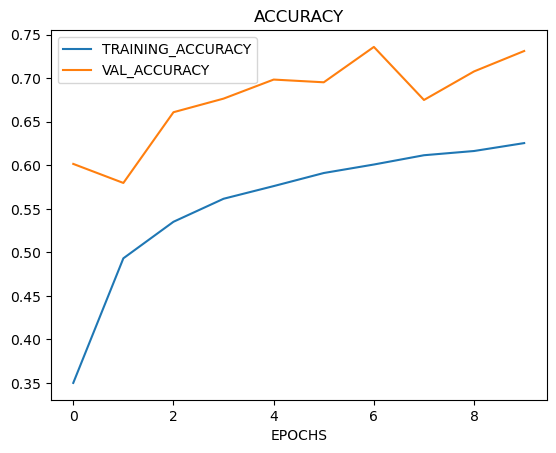

In [15]:
plot_loss_curves(history_1)

## 🛠 FINE-TUNING THE MODEL WITH DATA AUGMENTATION

In [16]:
# What Layers In The Model Are Trainable?
for layer in model_1.layers:
  print(layer.name, layer.trainable)

InputLayer True
DataAugmentationLayer True
inception_v3 False
GlobalAveragePoolingLayer True
OutputLayer True


In [17]:
# Checking Which Layers Are Trainable In Our Base Model
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [18]:
# Unfreezing All Of The Layers In The Base Model
base_model.trainable = True

# Refreezing Every Layer Except The Last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [19]:
# Checking Which Layers Are Trainable In Our Base Model
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

### 🧰 REFITTING

In [20]:
initial_epochs = 10

# Fine Tuning For Another 10 Epochs
fine_tune_epochs = initial_epochs + 10

# Refitting The Model
history_data_aug_fine_tuned = model_1.fit(train_data,
                                 epochs=fine_tune_epochs,
                                 validation_data=val_data,
                                 validation_steps=int(0.25 * len(val_data)),
                                 initial_epoch=history_1.epoch[-1])

Epoch 10/20
2561/2561 [==============================] - 1140s 445ms/step - loss: 1.9844 - accuracy: 0.6302 - val_loss: 0.9813 - val_accuracy: 0.7469
Epoch 11/20
2561/2561 [==============================] - 1139s 445ms/step - loss: 1.9584 - accuracy: 0.6354 - val_loss: 1.2350 - val_accuracy: 0.6984
Epoch 12/20
2561/2561 [==============================] - 1137s 444ms/step - loss: 1.9226 - accuracy: 0.6466 - val_loss: 1.0665 - val_accuracy: 0.7328
Epoch 13/20
2561/2561 [==============================] - 1141s 446ms/step - loss: 1.9280 - accuracy: 0.6458 - val_loss: 1.0666 - val_accuracy: 0.7359
Epoch 14/20
2561/2561 [==============================] - 1140s 445ms/step - loss: 1.9103 - accuracy: 0.6509 - val_loss: 1.0426 - val_accuracy: 0.7375
Epoch 15/20
2561/2561 [==============================] - 1145s 447ms/step - loss: 1.8748 - accuracy: 0.6539 - val_loss: 1.0494 - val_accuracy: 0.7266
Epoch 16/20
2561/2561 [==============================] - 1146s 447ms/step - loss: 1.8975 - accuracy:

In [21]:
# Evaluating The Fine Tuned Model
results_data_aug_fine_tuned = model_1.evaluate(test_data)

80/80 [==============================] - 33s 417ms/step - loss: 0.9822 - accuracy: 0.7494


### 🖥 SAVING THE MODEL

In [22]:
model_1.save(f'./Models/inceptionv3/data_aug_model_fine_tune_{results_data_aug_fine_tuned[1]}.h5')

### 📈 VISUALIZING THE LOSS CURVE

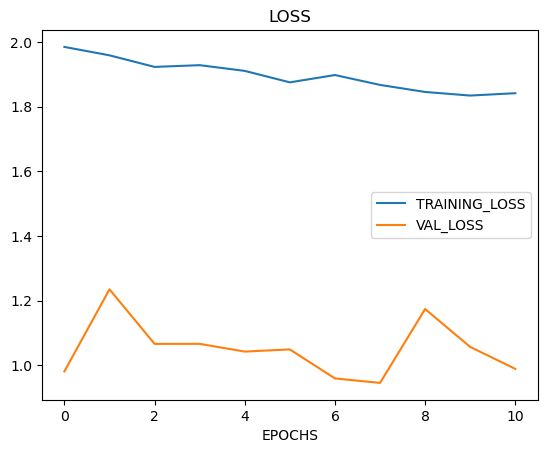

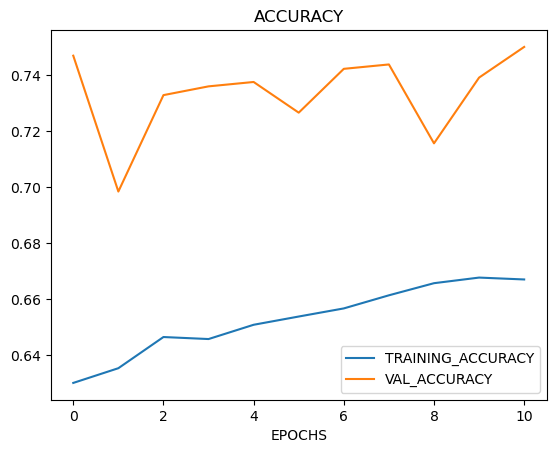

In [23]:
# Plotting The Loss Curves Of The Fine Tuned Model
plot_loss_curves(history_data_aug_fine_tuned)

### 📊 PLOTTING FINE-TUNED MODEL

In [24]:
compare_historys(history_1,
                 history_data_aug_fine_tuned,
                 initial_epochs=10)

NameError: name 'compare_historys' is not defined